In [1]:
using PyPlot
include("functions.jl")

MCMC (generic function with 1 method)

In [30]:
#Simulator to test estimation
censor_at = log10(20.0)
N = 32
fold_change = 20.0
founder_mean = 2.2
pooled_std = 0.3
measurement_std = 0.1
change_mean = -log10(fold_change)
change_std = 0.1
latent_neuts = rand(Normal(founder_mean,pooled_std),N)
random_slopes = rand(Normal(change_mean,change_std),N)

founder_neuts = latent_neuts .+ randn(N) .* measurement_std
variant_neuts = latent_neuts .+ random_slopes .+ randn(N) .* measurement_std

pre_censor_founder_neuts = copy(founder_neuts)
pre_censor_variant_neuts = copy(variant_neuts)

founder_neuts[founder_neuts .<= censor_at] .= censor_at
variant_neuts[variant_neuts .<= censor_at] .= censor_at;

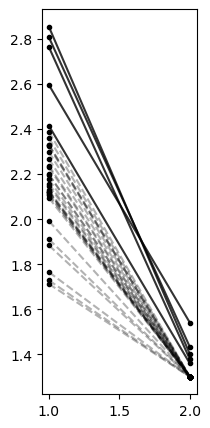

In [31]:
figure(figsize = (2,5))
for i in 1:N
    censored = variant_neuts[i] > censor_at && founder_neuts[i] > censor_at
    d = ifelse(censored,"-","--")
    a = ifelse(censored,0.8,0.3)
    plot([1,2],[founder_neuts[i],variant_neuts[i]],d,color = "black", alpha = a)
    plot([1],[founder_neuts[i]],".",color = "black")
    plot([2],[variant_neuts[i]],".",color = "black")
end

In [32]:
@time chain = MCMC(founder_neuts, variant_neuts, censor_at, maxiters = 10000000);
fold_change_chain = [c[2] for c in chain[1000:end]];
fold_change_HPDs = quantile(fold_change_chain,[0.025,0.5,0.975]);

 43.716513 seconds (241.47 M allocations: 29.610 GiB, 4.07% gc time)


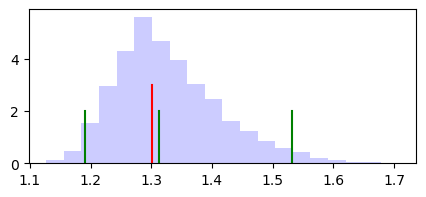

In [40]:
figure(figsize = (5,2))
hist(fold_change_chain,20,density = "true", color = "blue", alpha = 0.2);
plot([log10(fold_change),log10(fold_change)],[0.0,3.0], color = "red")
for i in 1:3
    plot([fold_change_HPDs[i],fold_change_HPDs[i]],[0.0,2.0], color = "green")
end

In [41]:
10 .^ fold_change_HPDs

3-element Vector{Float64}:
 15.526462836179903
 20.56134191847856
 34.0724299350224

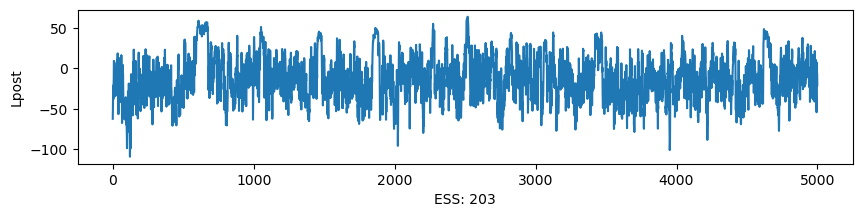

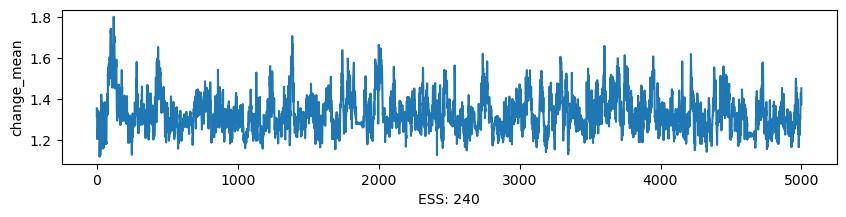

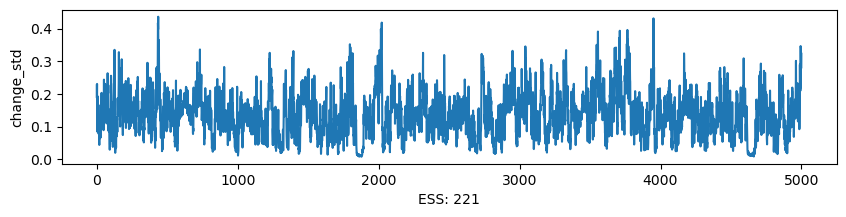

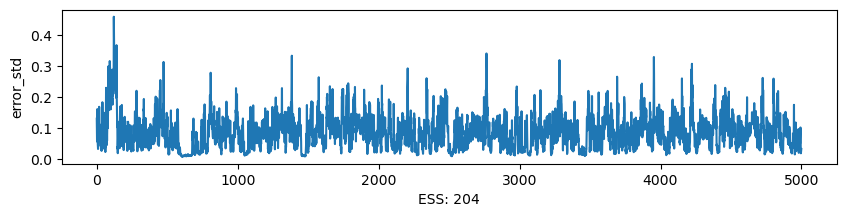

In [42]:
name_list = ["Lpost","change_mean","change_std","error_std"]
for i in 1:4
    figure(figsize = (10,2))
    v = [c[i] for c in chain]
    plot(v)
    xlabel("ESS: "*string(Int64(round(effective_sample_size(v[500:end])))))
    ylabel(name_list[i])
end

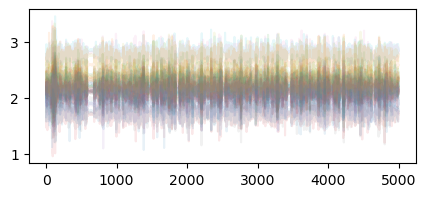

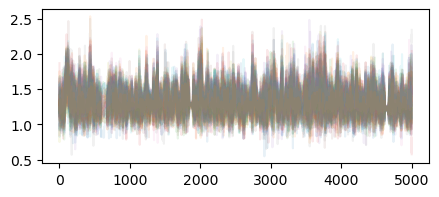

In [43]:
figure(figsize = (5,2))
plot([c[5] for c in chain], alpha = 0.1)
figure(figsize = (5,2))
plot([c[6] for c in chain], alpha = 0.1);

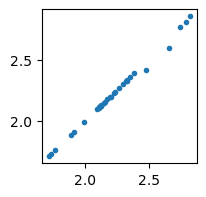

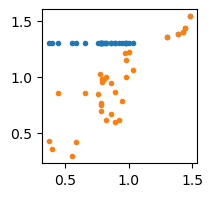

In [44]:
pos_mean_latents = mean(hcat([c[5] for c in chain]...),dims = 2)[:]
pos_mean_changes = mean(hcat([c[6] for c in chain]...),dims = 2)[:]
figure(figsize = (2,2))
plot(pos_mean_latents,founder_neuts,".")
figure(figsize = (2,2))
plot(pos_mean_latents-pos_mean_changes,variant_neuts,".")
plot(pos_mean_latents-pos_mean_changes,pre_censor_variant_neuts,".");